Can we capture the variability in both precip. and prob. of precip. with a single NN?

In [1]:
import os
from datetime import datetime
from torch.distributions import Beta
import wandb
import random
import numpy as np

In [2]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data.sampler import Sampler
import torch.optim.lr_scheduler as lr_scheduler

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# torch.set_default_device(device) ## set global device

In [4]:
import matplotlib.pyplot as plt
import itertools
import matplotlib
import datetime as dt
import glob
import bisect
import zipfile
import importlib

In [5]:
## no. of cpu workers
os.cpu_count()

40

In [6]:
import Data_loader
importlib.reload(Data_loader)
from Data_loader import PrcNorm, ThermoNorm, LoadTraining, Normalize, CustomSampler

In [7]:
def set_seed(seed: int = 0) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 0


Set data paths

In [8]:
PROJ_PATH='/ocean/projects/ees220002p/fiaz/'
IMERG_ERA5_PATH=PROJ_PATH+'ocn/'
PRC_PATH=IMERG_ERA5_PATH+'prc_ocn/prc_oceans_2015_01_01.npy'
HBL_PATH=IMERG_ERA5_PATH+'hbl_ocn/hbl_oceans_2015_01_01.npy'
HLFT_PATH=IMERG_ERA5_PATH+'hlft_ocn/hlft_oceans_2015_01_01.npy'
HSAT_LFT_PATH=IMERG_ERA5_PATH+'hsat_lft_ocn/hsat_lft_oceans_2015_01_01.npy'

Get normalizers

In [9]:
imerg_prc=PrcNorm(PRC_PATH)
imerg_prc.compute_norm()

In [10]:
era5_thermo=ThermoNorm(HBL_PATH,HLFT_PATH,HSAT_LFT_PATH)
era5_thermo.compute_norm()

In [11]:
### Declare directories ###
fils_hbl=glob.glob(IMERG_ERA5_PATH+'hbl_ocn/hbl_oceans_*npy')
fils_hbl.sort()

In [12]:
era5_hlft_dir=IMERG_ERA5_PATH+'hlft_ocn/'
era5_hsat_lft_dir=IMERG_ERA5_PATH+'hsat_lft_ocn/'
imerg_prc_dir=IMERG_ERA5_PATH+'prc_ocn/'

In [13]:

prc_norm_dict={'prc_mean':0,
               'prc_std':imerg_prc.precipitating_std}

thermo_norm_dict={'instab_mean':era5_thermo.instab_mean,
                 'instab_std':era5_thermo.instab_std,
                 'subsat_mean':era5_thermo.subsat_mean,
                 'subsat_std':era5_thermo.subsat_std}

In [14]:
BATCH_SIZE=256

In [15]:
fil_locations={'hlft_dir':era5_hlft_dir,
              'hlft_sat_dir':era5_hsat_lft_dir,
              'prc_dir':imerg_prc_dir,
               'prc_norm':prc_norm_dict, 
               'thermo_norm':thermo_norm_dict,
              'batch_size':BATCH_SIZE}

Dataset=torch.utils.data.Dataset
Dataloader=torch.utils.data.DataLoader

class DataGenerator(Dataset):
    def __init__(self,fils:str,
                 hlft_dir:str,hlft_sat_dir:str,prc_dir:str,
                 prc_norm:dict,thermo_norm:dict,
                batch_size:int):
        
        self.fils=fils
        self.hlft_dir=hlft_dir
        self.hlft_sat_dir=hlft_sat_dir
        self.prc_dir=prc_dir
        
        ## get norm. values from dict ###
        self.prc_mean = prc_norm['prc_mean']
        self.prc_std = prc_norm['prc_std']
        
        self.instab_mean = thermo_norm['instab_mean']
        self.instab_std = thermo_norm['instab_std']
        
        self.subsat_mean = thermo_norm['subsat_mean']
        self.subsat_std = thermo_norm['subsat_std']
        
        #############
        
        self.total_size=0 ## store total number of samples
        self.fil_bounds=[] ## store bounds to identify each npy file
        
        for fil in self.fils:
            fil_len=(np.load(fil,mmap_mode='r').size//batch_size)*batch_size
            self.total_size+=fil_len 
            self.fil_bounds.append(self.total_size) 
            
    def __len__(self)->int:
        return self.total_size
    
    def __normalize(self, x,xbar,normalizer):
        return (x-xbar)/normalizer

    
    def __getitem__(self,idx):

        ## get fil_idx and array_idx using idx ##
        fil_idx=[idx//i for i in self.fil_bounds].index(0) ## get file to open
        fil=self.fils[fil_idx]
        
        if fil_idx>0:
            array_idx=idx-self.fil_bounds[fil_idx-1] 
        else:
            array_idx=idx
        
        ##open files ###
        date_str=fil.split('hbl_oceans_')[-1].split('.npy')[0]
        
        fils_prc=self.prc_dir+f"prc_oceans_{date_str}.npy"
        fils_hlft=self.hlft_dir+f"hlft_oceans_{date_str}.npy"
        fils_hsat_lft=self.hlft_sat_dir+f"hsat_lft_oceans_{date_str}.npy"

        hbl=np.load(fil,mmap_mode='r')[array_idx]
        hlft=np.load(fils_hlft,mmap_mode='r')[array_idx]
        hsat_lft=np.load(fils_hsat_lft,mmap_mode='r')[array_idx]
        prc=np.load(fils_prc,mmap_mode='r')[array_idx]
        
                
        ## compute instab and subsat
        instab=(hbl-hsat_lft)*340./hsat_lft
        subsat=(hsat_lft-hlft)*340./hsat_lft
        
        ### normalize data ###
        
        instab=self.__normalize(instab, self.instab_mean,self.instab_std)
        subsat=self.__normalize(subsat, self.subsat_mean,self.subsat_std)
        prc=self.__normalize(prc, self.prc_mean,self.prc_std)
        
        return instab, subsat, prc
        
training_data=DataGenerator(fils_hbl[:2],**fil_locations)
training_generator=torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, 
                           shuffle=True, num_workers=0,
                           pin_memory=True)

In [16]:
print(f'Training {len(training_data)} samples in {len(training_generator)} batches')

Training 14327808 samples in 55968 batches


### Check dataloader output ###

In [ ]:
# %%timeit -n1 -r1

instab=[]
subsat=[]
prc=[]

for i_batch, samples in enumerate(training_generator):
    
    instab.append(samples[0].detach().numpy())
    subsat.append(samples[1].detach().numpy())
    prc.append(samples[2].detach().numpy())
    
    if i_batch==50:
        break



In [ ]:
plt.plot(np.concatenate(instab)[:256])

In [ ]:
fig,axx=plt.subplots(1,3,figsize=(8,2.5))

ax=axx[0]
ax.hist(np.concatenate(instab).flatten())

ax=axx[1]
ax.hist(np.concatenate(subsat).flatten())

ax=axx[2]
# ax.hist(np.concatenate(conv_prc)*prc_norm_dict['normalizer'].flatten(),density=True)
ax.hist(np.concatenate(prc),density=True)

ax.set_yscale('log')
ax.set_xlim(right=20)
# ax=axx[1,0]
# ax.hist(np.concatenate(conv_nn_prc)*prc_norm.flatten())
# ax.set_yscale('log')

# ax=axx[1,1]
# ax.hist(np.concatenate(imerg_prc_tm1)*prc_norm.flatten())
# ax.set_yscale('log')

plt.tight_layout()

### Import model ###

In [40]:
import Vae_model 
import sys
importlib.reload(Vae_model)

<module 'Vae_model' from '/jet/home/fiaz/precip-vae/Vae_model.py'>

In [41]:
LATENT_DIMS=1
INPUT_DIMS=3
NN_DIMS_ENC=12
NN_DIMS_DEC=12

model=Vae_model.CVAE_ORG_mod(LATENT_DIMS,INPUT_DIMS,
                                             NN_DIMS_ENC,NN_DIMS_DEC).to(device)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-4,
                            weight_decay=1e-3)
# 
# train_opt=torch.compile(model)

### Test

In [19]:
from operator import mul
from functools import reduce # python3 compatibility

network_size=0
for params in model.parameters():
    network_size+=reduce(mul, params.size(), 1)
print('total number of parameters: {:d}'.format(network_size))

total number of parameters: 365


In [ ]:
startTime=datetime.now()

for i_batch, sample_batched in enumerate(training_generator):
    
    
    data=torch.stack(sample_batched,dim=1).unsqueeze(2)
    
    ## transfer to GPU

    print([f"{round(i*1e-9,3)} GB" for i in torch.cuda.mem_get_info()])
    sTime=datetime.now()
    data=data.float().to(device)
    print(f"GPU transfer took {(datetime.now() - sTime).total_seconds()/60} minutes")
    print([f"{round(i*1e-9,3)} GB" for i in torch.cuda.mem_get_info()])

    optimizer.zero_grad()
    
    outputs=model(data)
    kl_loss, binary_loss, gamma_loss, gaussian_loss\
    =model.vae_loss(outputs)
#     , gamma_nll_1, gamma_nll_2, gamma_nll_3, gamma_nll_4\  
    

    syn_size=1_000_000
    z=torch.normal(mean=0.,std=1.,
                                size=(syn_size,LATENT_DIMS)).to(device)
    
    input_tensor=torch.cat((torch.tensor([1.0]).unsqueeze(1),
                        torch.tensor([-1]).unsqueeze(1)),axis=1).to(device)    
    
    Vae_model.print_params(z,model,input_tensor)

    break
    
print(f"Took {(datetime.now() - startTime).total_seconds()/60} minutes")



### Train

In [20]:
ALPHA_W=0.75

In [21]:
EPOCHS = 1
wandb.finish()

In [ ]:
# # start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="precip-VAE",
#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": optimizer.param_groups[0]['lr'],
#     "architecture": "VAE",
#     "dataset": "GPM/ERA5",
#     "epochs": EPOCHS,
#     "batch size":BATCH_SIZE,
#     "NN DIMD": NN_DIMS_DEC,
#     "NN_DIME": NN_DIMS_ENC,
#     "Latent DIM": LATENT_DIMS,
#     "Predictor": "lrh",
#     "alpha_w":ALPHA_W,
#     }
# )

Random seed set as 0
Total time: 0.05 minutes
EPOCH 1:
0
Took: 7.000565528869629e-05 seconds
1
Took: 7.77076929807663e-05 seconds
2
Took: 7.763132452964783e-05 seconds
3
Took: 0.00010573118925094604 seconds
4
Took: 7.231347262859344e-05 seconds
5
Took: 7.672049105167389e-05 seconds
6
Took: 7.48559832572937e-05 seconds
7
Took: 7.524341344833374e-05 seconds
8
Took: 7.181428372859955e-05 seconds
9
Took: 7.04638659954071e-05 seconds
10
Took: 0.00024301744997501373 seconds
11
Took: 0.0002592019736766815 seconds
12
Took: 0.00024289824068546295 seconds
13
Took: 7.419288158416748e-05 seconds


KeyboardInterrupt: 

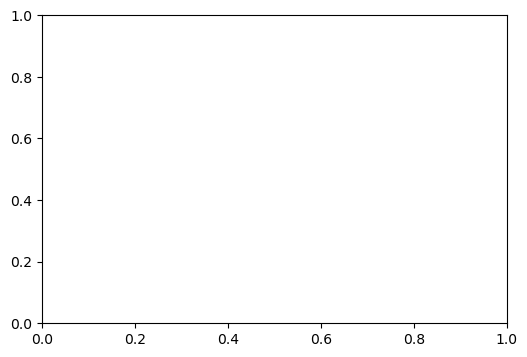

In [42]:
startTime1 = datetime.now()
SAVE_MODEL=False
MODEL_NAME_STR='cvae_tr2_imerg_era5_gamma_gauss_alpha_w={}'.format(ALPHA_W)

fig,axx=plt.subplots(1,1,figsize=(6,4))
ax=axx
losses={'elbo':[],'gamma':[], 
        'gauss':[],'binary':[], 'kl':[]}

set_seed()
epoch_number = 0
best_vloss = 1_000_000.

syn_size=1_000_000

z=torch.normal(mean=0.,std=1.,size=(syn_size,LATENT_DIMS)).to(device)

input_tensor=torch.cat((torch.tensor([1.0]).unsqueeze(1),
                    torch.tensor([-1]).unsqueeze(1)),axis=1).to(device)    

print("Total time: {:.2f} minutes".format((datetime.now() - startTime1).total_seconds()))


for epoch in range(EPOCHS):
    startTime2 = datetime.now()
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    mean_ELBO, mean_gamma_loss, mean_gaussian_loss, mean_KL_loss, mean_binary_loss\
    = Vae_model.train_one_epoch(epoch_number,training_generator,model,
                                                optimizer,ALPHA_W)
    
#     losses['elbo'].append(mean_ELBO)
#     losses['gamma'].append(mean_gamma_loss)
#     losses['gauss'].append(mean_gaussian_loss)
#     losses['binary'].append(mean_binary_loss)
#     losses['kl'].append(mean_KL_loss)
    
    # We don't need gradients on to do reporting
    model.train(False)
    
    Vae_model.print_params(z,model,input_thermo_tensor)

#     ax.scatter(epoch,mean_ELBO,color='black')
#     ax.scatter(epoch,mean_gamma_loss,color='red')
#     ax.scatter(epoch,mean_KL_loss,color='blue')
#     ax.scatter(epoch,mean_binary_loss,color='orange')
    
    epoch_number += 1
    print("Time for epoch: {:.2f} minutes".format((datetime.now() - startTime2).total_seconds()/60))
        
#     wandb.log({"ELBO": mean_ELBO, "gamma loss": mean_gamma_loss,
#                "gaussian loss":mean_gaussian_loss,
#               "binary loss": mean_binary_loss, "KL loss": mean_KL_loss})

    if SAVE_MODEL:
        dir_name='/ocean/projects/ees220002p/fiaz/trained_models/'

        model_name_prev=MODEL_NAME_STR+'_{}_epochs.pth'.format(epoch_number-1)
        model_name=MODEL_NAME_STR+'_{}_epochs.pth'.format(epoch_number)

        if epoch_number>1:
            os.remove(dir_name+model_name_prev)
        torch.save(model.state_dict(), dir_name+model_name)
        print('Model saved as {}'.format(dir_name+model_name))
        
print("Total time: {:.2f} minutes".format((datetime.now() - startTime1).total_seconds()/60))

# wandb.finish()

## Small scale parameters suggest small tails. 

### Diagnose

In [ ]:
# dst='/home/fiaz/ML/vae/models/cvae_gamma_conv_rain_singleED_50_epochs.pth'
# dst='/home/fiaz/ML/vae/models/cvae_gamma_conv_rain_singleED_NN=4_LD=1_48_epochs.pth'
# dst='/home/fiaz/ML/vae/models/cvae_gamma_conv_rain_singleED_NN=4_LD=2_7_epochs.pth'
# model.load_state_dict(torch.load(dst))
Vae_model.print_params(z,model,torch.tensor([0.8]))



In [ ]:
pcp_bins=2**(np.arange(-2.,8.125,0.125))
pcp_bins=np.insert(pcp_bins,0,1e-3)
pcp_bin_center=(pcp_bins[1:]+pcp_bins[:-1])*0.5
dx=np.diff(pcp_bins)

In [ ]:
import matplotlib
colors_norm1 = matplotlib.colors.Normalize(vmin=0, vmax=1.)
cmap = plt.get_cmap('YlOrRd')
col = matplotlib.cm.ScalarMappable(norm=colors_norm1, cmap=cmap)

colors_norm = matplotlib.colors.Normalize(vmin=-3, vmax=3.)
colz = matplotlib.cm.ScalarMappable(norm=colors_norm, cmap=cmap)

In [ ]:
syn_size=1_000_00
synthetic_input=torch.normal(mean=0.,std=1.,
                            size=(syn_size,LATENT_DIMS))


fig,axx=plt.subplots(2,2,figsize=(8.,5.))

for i in np.arange(0,0.95,.05)[::4]: 
    print(i)
#     synthetic_input[:,0]=3
    synthetic_input[:]=4.

    crh_cond=torch.ones([syn_size,1])
    crh_cond[:]=i
    
    log_alpha,log_beta, prob=model.decoder(synthetic_input,crh_cond)
    m1=torch.distributions.Gamma(log_alpha.exp(),log_beta.exp())
    m2=torch.distributions.Bernoulli(prob)
    
    prc_array= (m2.sample()*m1.sample()*prc_std).numpy().squeeze()
    
    prc_hist=np.histogram(prc_array,bins=pcp_bins)[0]
    prc_hist=prc_hist/(dx*prc_hist.sum())
    
    axx[0,0].scatter(pcp_bin_center,prc_hist,color=col.to_rgba(i))
    axx[0,1].hist(prob.detach().numpy().squeeze(),color=col.to_rgba(i))
    
#     if i==.5:
#         break
    
    
for i in np.arange(-3,3.2,0.2):
    
#     synthetic_input[:,0]=i
    synthetic_input[:]=i

    crh_cond=torch.ones([syn_size,1])
    crh_cond[:]=0.8
    
    log_alpha, log_beta, prob=model.decoder(synthetic_input,crh_cond)
    m1=torch.distributions.Gamma(log_alpha.exp(),log_beta.exp())
    m2=torch.distributions.Bernoulli(prob)
    
    prc_array= (m2.sample()*m1.sample()*prc_norm).numpy().squeeze()
    
    prc_hist=np.histogram(prc_array,bins=pcp_bins)[0]
    prc_hist=prc_hist/(dx*prc_hist.sum())
    
    axx[1,0].scatter(pcp_bin_center,prc_hist,color=colz.to_rgba(i))
    axx[1,1].hist(prob.detach().numpy().squeeze(),color=colz.to_rgba(i))
    
    
axx[0,0].set_yscale('log')
axx[1,0].set_yscale('log')
axx[0,0].set_xlim(0,250)
axx[1,0].set_xlim(0,250)

for ax in axx[0]:
    ax.tick_params(which='both',labelsize=13)

for ax in axx[1]:
    ax.tick_params(which='both',labelsize=13)

# axx[0,1].set_xlabel('Shape',fontsize=13)
# axx[1,1].set_xlabel('Scale',fontsize=13)
    
plt.tight_layout()